In [1]:
import warnings
warnings.filterwarnings("ignore")
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import env, acquire

In [2]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
query = """select calculatedfinishedsquarefeet, bathroomcnt, bedroomcnt, taxvaluedollarcnt
           from properties_2017
           join predictions_2017 using(parcelid)
           where transactiondate between '2017-05-01' and '2017-06-30'
           and propertylandusetypeid in (261, 262, 263, 264, 266, 268, 273, 275, 276, 279)
        """

def get_zillow_data():
    filename = 'zillow.csv'
    
    if os.path.isfile(filename):
        return pd.read_csv(filename, index_col=0)
    else:
        df = pd.read_sql(query, get_connection('zillow'))
        df.to_csv(filename)
        return df

## Data Acquisition

In [4]:
df = acquire.acquire_cache_data()
df.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
0,1458.0,2.0,3.0,136104.0
1,1421.0,1.0,2.0,35606.0
2,2541.0,3.0,4.0,880456.0
3,1650.0,2.0,3.0,614000.0
4,693.0,1.0,2.0,274237.0


## Data Preparation
### Summarize the data
- df.info()
- df.describe()
- df.dtypes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20364 entries, 0 to 20363
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20318 non-null  float64
 1   bathroomcnt                   20364 non-null  float64
 2   bedroomcnt                    20364 non-null  float64
 3   taxvaluedollarcnt             20364 non-null  float64
dtypes: float64(4)
memory usage: 636.5 KB


In [6]:
df. describe()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
count,20318.000000,20364.000000,20364.000000,2.036400e+04
mean,1776.493208,2.284694,3.019839,5.054039e+05
std,936.606498,0.958072,1.030974,6.584038e+05
min,242.000000,0.000000,0.000000,1.050400e+04
25%,1176.000000,2.000000,2.000000,2.104808e+05
50%,1536.000000,2.000000,3.000000,3.665045e+05
75%,2102.000000,3.000000,4.000000,5.890250e+05
max,15450.000000,11.000000,12.000000,2.385837e+07


In [7]:
df.dtypes

calculatedfinishedsquarefeet    float64
bathroomcnt                     float64
bedroomcnt                      float64
taxvaluedollarcnt               float64
dtype: object

### Address missing values
**Takeways**
- 70 observations has bathroom count 0
- 136 observations has bedroom count 0
- 46 observations has square feet as null
- How to deal with them? Drop all the observations with 0 or NaN values

In [8]:
df[df.bathroomcnt == 0].shape

(70, 4)

In [9]:
df[df.bedroomcnt == 0].shape

(136, 4)

In [10]:
df.calculatedfinishedsquarefeet.isnull().sum()

46

In [11]:
# Drop all the obervations with null or 0

mask_bathr = (df.bathroomcnt == 0)
mask_bedr = (df.bedroomcnt == 0)
mask_sf = df.calculatedfinishedsquarefeet.isnull()

mask = mask_bathr | mask_bedr | mask_sf
mask.sum()

df = df[-mask]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20223 entries, 0 to 20363
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20223 non-null  float64
 1   bathroomcnt                   20223 non-null  float64
 2   bedroomcnt                    20223 non-null  float64
 3   taxvaluedollarcnt             20223 non-null  float64
dtypes: float64(4)
memory usage: 790.0 KB


In [12]:
# Double check to make sure my code remove all the missing values.

bathr_missing = df[df.bathroomcnt == 0].shape[0]
bedr_missing = df[df.bedroomcnt == 0].shape[0]
sf_missing = df.calculatedfinishedsquarefeet.isnull().sum()

bathr_missing, bedr_missing, sf_missing

(0, 0, 0)

### Address dupliates
**Takeways**
- 61 obervations were duplicates
- How to deal with them? Drop all the duplicates

In [13]:
df.duplicated().sum()

58

In [14]:
df = df.drop_duplicates(keep='first', ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20165 entries, 0 to 20164
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20165 non-null  float64
 1   bathroomcnt                   20165 non-null  float64
 2   bedroomcnt                    20165 non-null  float64
 3   taxvaluedollarcnt             20165 non-null  float64
dtypes: float64(4)
memory usage: 630.3 KB


In [15]:
df.describe()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
count,20165.000000,20165.000000,20165.000000,2.016500e+04
mean,1780.902108,2.297595,3.041706,5.047822e+05
std,932.715302,0.948802,0.999601,6.554203e+05
min,242.000000,1.000000,1.000000,1.050400e+04
25%,1179.000000,2.000000,2.000000,2.107920e+05
50%,1540.000000,2.000000,3.000000,3.674520e+05
75%,2107.000000,3.000000,4.000000,5.900000e+05
max,15450.000000,11.000000,12.000000,2.385837e+07


### Visuzliaztion the variables

In [16]:
plt.rc('font',size=13)
plt.rc('figure', figsize=(13,7))

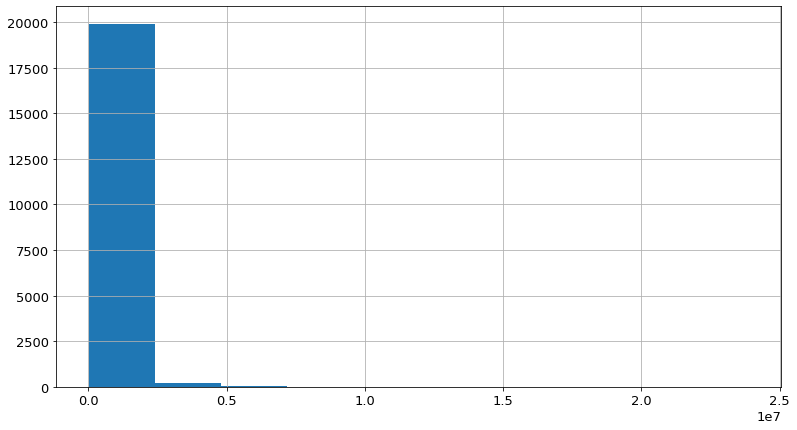

In [17]:
# Plot the distribution of the target variable: taxvaluedollarcnt

df.taxvaluedollarcnt.hist()

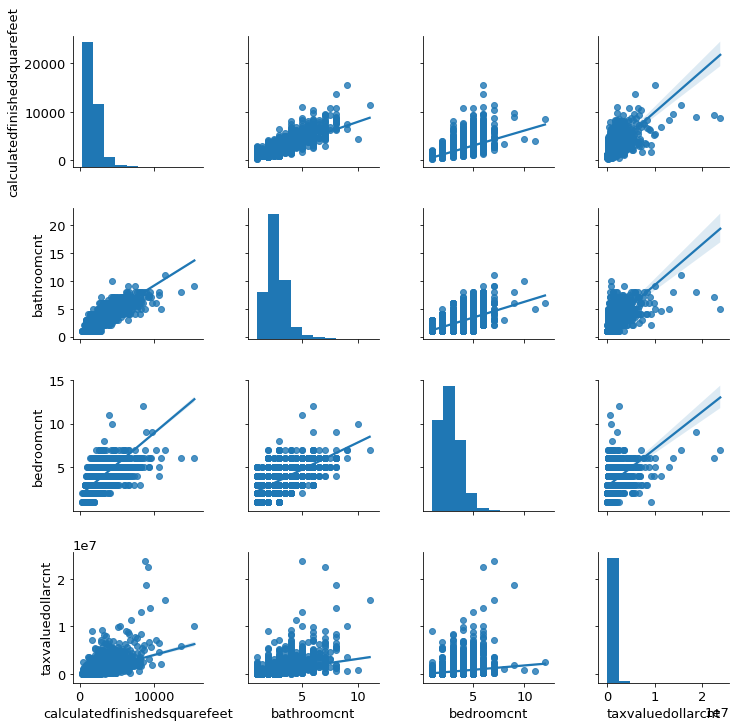

In [18]:
# Pairplot the variables

sns.pairplot(df, kind='reg')

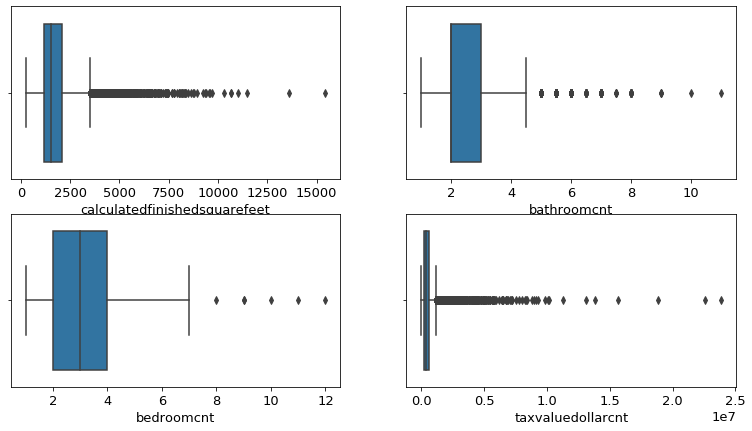

In [19]:
# Box-plot all the variables

plt.subplot(221)
sns.boxplot(df.calculatedfinishedsquarefeet)

plt.subplot(222)
sns.boxplot(df.bathroomcnt)

plt.subplot(223)
sns.boxplot(df.bedroomcnt)

plt.subplot(224)
sns.boxplot(df.taxvaluedollarcnt)

### Splitting the data into train, validate and test

In [22]:
df.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
0,1458.0,2.0,3.0,136104.0
1,1421.0,1.0,2.0,35606.0
2,2541.0,3.0,4.0,880456.0
3,1650.0,2.0,3.0,614000.0
4,693.0,1.0,2.0,274237.0


In [32]:
df.taxvaluedollarcnt

0        136104.0
1         35606.0
2        880456.0
3        614000.0
4        274237.0
           ...   
20160    359829.0
20161    297097.0
20162    746963.0
20163    579047.0
20164    630933.0
Name: taxvaluedollarcnt, Length: 20165, dtype: float64

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20165 entries, 0 to 20164
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20165 non-null  float64
 1   bathroomcnt                   20165 non-null  float64
 2   bedroomcnt                    20165 non-null  float64
 3   taxvaluedollarcnt             20165 non-null  float64
dtypes: float64(4)
memory usage: 630.3 KB


In [35]:
import prepare

train, validate, test = prepare.split_my_data(df, pct=0.1)
train.shape, validate.shape, test.shape

((14518, 4), (3630, 4), (2017, 4))

In [36]:
train.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
16476,1476.0,2.0,3.0,409397.0
17919,1603.0,2.0,3.0,231346.0
3622,1579.0,2.0,3.0,169559.0
16863,1458.0,2.5,2.0,225597.0
15808,2338.0,3.0,4.0,288753.0


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14518 entries, 16476 to 18804
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  14518 non-null  float64
 1   bathroomcnt                   14518 non-null  float64
 2   bedroomcnt                    14518 non-null  float64
 3   taxvaluedollarcnt             14518 non-null  float64
dtypes: float64(4)
memory usage: 567.1 KB


In [38]:
# Value error when I tried to stratify the target variables

train_stratified, validate_stratified, test_stratified = prepare.split_stratify_my_data(df,
                                                                                        'taxvaluedollarcnt',
                                                                                        pct=0.1)
train_stratified.shape, validate_stratified.shape, test_stratified.shape

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [40]:
scaler, train_scaled, validate_scaled, test_scaled = prepare.min_max_scaler(train, validate, test)
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((14518, 4), (3630, 4), (2017, 4))

In [41]:
train_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
16476,0.114492,0.111111,0.222222,0.017615
17919,0.126276,0.111111,0.222222,0.009729
3622,0.124049,0.111111,0.222222,0.006993
16863,0.112822,0.166667,0.111111,0.009475
15808,0.194470,0.222222,0.333333,0.012272


In [ ]:
def pre_zillow(df):
    